# 03 Visual search with k-NN
---
# Checklist
- [x] k-NN performance
- [x] 10 nearest neighbors

# MAIN TASK: Evaluate Accuracy of knn classifiers and find parametres of the best performing model
* the overall accuracy of knn clasifiers was relatively high, and majority of classifiers achieved accuracy equal to, or higher then 0.8
* Optimal k value was from 5 up to 26, and it variaried depending on the model used. 
* In addition to comparing the influence of k on knn-model accuracy, I compared knn-models contructed with different number of features. For that purpose I used all features extracted with imagenet, and a subset of pca principial axes (10, 30, and 250). The results showed clearly that models constructed with smaller number of principial axes,  or the models using all extracted features without PCA, performed better then similar models contrsucted with higher number of princpial axes (30, or 250). 
* inpout data scaling had no strong effect on model performance, whereas distance weights had very positive effect on performace of knn-models constructed with large number of pca principial axes as input data (250). In that case, knn models using uniform weights produced validations scores similar to most frequent baseline, and the models using distance weights were able to produce vasliadaiton scores over 0.9. 
* Importnat observation: knn models are difficult to store due to their size

In [19]:
import os # allow changing, and navigating files and folders, 
import sys
import re # module to use regular expressions, 
import glob # lists names in folders that match Unix shell patterns
import random # functions that use and generate random numbers

import pickle
import joblib
import numpy as np # support for multi-dimensional arrays and matrices
import pandas as pd # library for data manipulation and analysis
import seaborn as sns # advance plots, for statistics, 
import matplotlib as mpl # to get some basif functions, heping with plot mnaking 
import matplotlib.pyplot as plt # for making plots, 

from PIL import Image, ImageDraw
from IPython.display import display
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
import graphviz # allows visualizing decision trees,
from IPython.display import display # allows displaying pd, dataframes

In [20]:
os.chdir(basedir)
sys.path.append(basedir)

# my tools, loaded only form basedir, 
from src.utils.data_loaders import load_encoded_imgbatch_using_logfile, load_raw_img_batch
from src.utils.example_plots_after_clustering import plot_img_examples, create_spaces_between_img_clusters, plot_img_examples_from_dendrogram
from src.utils.annotated_pie_charts import annotated_pie_chart_with_class_and_group, prepare_img_classname_and_groupname
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.logreg_tools import my_logredCV
from src.utils.random_forest import random_forest_grid_search, plot_random_tree_summary_andor_table
from src.utils.SVM_tools import SVM_grid_search, plot_grid_acc_and_return_summary_df
from src.utils.tools_for_plots import create_class_colors_dict
from src.utils.model_summary_plots import plot_grid_acc_and_return_summary_df, visual_model_summary, model_gridsearch_summary_plots
from src.utils.knn_tools import knn_grid_search

# one of my functions was generating warnign, on copies, despite using proper syntax, 
import warnings
warnings.filterwarnings("ignore")

# Train k-NN models

In [4]:
# Prepare grid, for pipeline 
grid = ParameterGrid({
    'scaler': [None, StandardScaler()],      # scaler user or not, 
    'knn__n_neighbors': list(range(2,31,1)), # I do not use k==1, !
    'knn__weights': ['uniform', 'distance'], # Weighting function
    'knn__p': [1, 2],                        # L1 and L2 distance metrics
    'pca':[0, 10, 30, 250]
});


# Grid search on each module, with results saved in designated direcotsy with full informative name, 
for module_name in module_names:

    
    print(f"{len(grid)} parameter combinations will be evaluated")
    print(f"if will take approximately {np.round(len(grid)*18/1000, 1)} min")
    
    
    # step 1. run grid search, 
    dt_results_list, model_predictions_dict = knn_grid_search(
        method_name=task_name, 
        path=PATH_encoded, # path to extracted features, 
        dataset_name=dataset_name, 
        subset_names_tr=train_subset_names, 
        subset_names_te=test_subset_names, 
        module_names=[module_name], # must be a list ! with at least on item, 
        class_encoding=dict(zip(list(class_colors.keys()), list(range(len(class_colors))))), 
        grid=grid, 
        param_names_for_Classifier=['scaler', 'knn__n_neighbors', 'knn__weights', 'knn__p'],  
        track_progresss=True,
    )

    # STEP 2. save files 
    os.chdir(PATH_results)

    # .. save summary table
    pd.DataFrame(dt_results_list).to_csv(f"{task_name}__{module_name}__{dataset_name}__summary_table.csv", header=True)

    # .. save the model_predictions_dict into a pickle file
    with open(f"{task_name}__{module_name}__{dataset_name}__model_predictions_dict.p", 'wb') as file: # wb - write binary,
        pickle.dump(model_predictions_dict, file) 


928 parameter combinations will be evaluated
if will take approximately 16.7 min
0 imagenet _________________________________________ 2020-11-11 11:21:36.842487
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

# EVALUATE DETAILS OF TESTED k-NN MODELS 
---

## Show table with top ten performing k-NN models, 
Table Interpretation:
* NaN - eg: in columns 'scaler' denotes None, or, not used, value used in Parametergrid
* pca_componetss_used : if equal to 0, PCA was not used, and all available features extracted with tfhub module were used to build the model


In [22]:
# sort summary table 
features_to_display = ["model_ID", "module", "model_acc_valid", "model_acc_train", 'scaler', 'knn__n_neighbors', 'knn__weights', 'knn__p', "pca_components_used"]
df_sorted = summary_df.sort_values("model_acc_valid", ascending=False).loc[:,features_to_display].head(10)
display(df_sorted.head(10))

,model_ID,module,model_acc_valid,model_acc_train,scaler,knn__n_neighbors,knn__weights,knn__p,pca_components_used
498,498,imagenet,0.928571,0.924915,NaN,17,uniform,2,10
113,113,imagenet,0.928571,0.941980,"StandardScaler(copy=True, with_mean=True, with...",5,uniform,2,0
771,771,imagenet,0.928571,0.907850,"StandardScaler(copy=True, with_mean=True, with...",26,uniform,1,10
770,770,imagenet,0.928571,0.897611,NaN,26,uniform,1,10
362,362,imagenet,0.928571,1.000000,NaN,13,distance,1,10
579,579,imagenet,0.928571,0.914676,"StandardScaler(copy=True, with_mean=True, with...",20,uniform,1,10
354,354,imagenet,0.928571,0.914676,NaN,13,uniform,1,10
762,762,imagenet,0.928571,1.000000,NaN,25,distance,2,10
754,754,imagenet,0.928571,0.921502,NaN,25,uniform,2,10
730,730,imagenet,0.928571,1.000000,NaN,24,distance,2,10


# Compare train and validation accuracy of models created using different combinations of parameters and data preparation approaches
---
* The Table below figures shows the best performing model from each plot, with relevant parameters

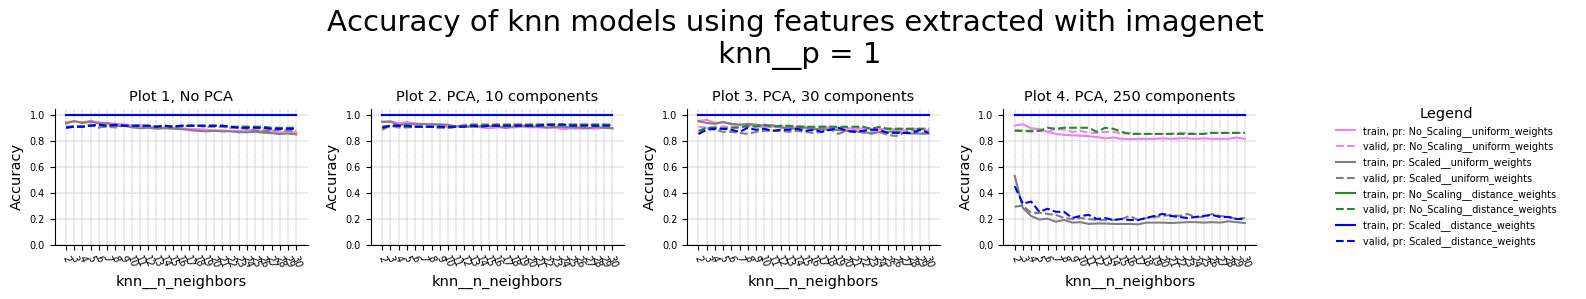

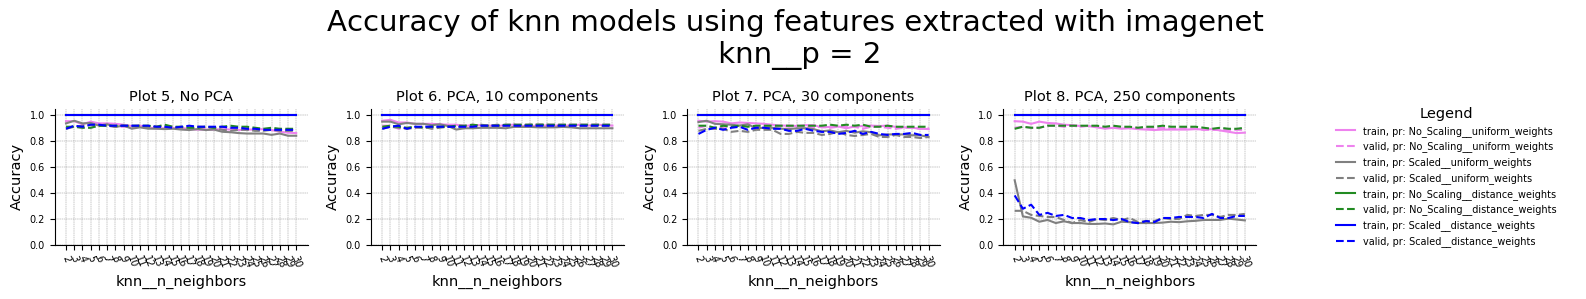

,Plot_nr,model_ID,method,module,model_acc_train,model_acc_valid,model_acc_test,knn__p,pca_components_used,knn__n_neighbors,pr,baseline_acc_train,baseline_acc_valid,baseline_acc_test
3,Plot 4,142,knn,imagenet,1.000000,0.904762,0.86,1,250,6,No_Scaling__distance_weights,0.245734,0.190476,0.22
7,Plot 8,150,knn,imagenet,0.941980,0.920635,0.94,2,250,6,No_Scaling__uniform_weights,0.245734,0.190476,0.22
0,Plot 1,96,knn,imagenet,0.959044,0.928571,0.88,1,0,5,No_Scaling__uniform_weights,0.245734,0.190476,0.22
1,Plot 2,322,knn,imagenet,0.911263,0.928571,0.92,1,10,12,No_Scaling__uniform_weights,0.245734,0.190476,0.22
2,Plot 3,268,knn,imagenet,1.000000,0.928571,0.94,1,30,10,No_Scaling__distance_weights,0.245734,0.190476,0.22
4,Plot 5,113,knn,imagenet,0.941980,0.928571,0.90,2,0,5,Scaled__uniform_weights,0.245734,0.190476,0.22
5,Plot 6,306,knn,imagenet,0.928328,0.928571,0.94,2,10,11,No_Scaling__uniform_weights,0.245734,0.190476,0.22
6,Plot 7,540,knn,imagenet,1.000000,0.928571,0.94,2,30,18,No_Scaling__distance_weights,0.245734,0.190476,0.22


In [23]:
best_performing_model_on_each_plot = model_gridsearch_summary_plots(
                data=summary_df, 
                module_names=module_names,
                fig_title_prefix = f"Accuracy of {task_name} models using features extracted with {module_name}\n knn__p =",
                fig_dname        = "knn__p",
                subplots_dname   = "pca_components_used",
                xaxis_dname      = "knn__n_neighbors",
                linecolor_dname  = "pr",
                linestyle_dnames = ["train", "valid"],
)

# find 10 neairest neighbours for each image in test data


Acc, train data: 1.000
Acc, test data: 0.940
Found 280 images belonging to 6 classes.
Found 139 images belonging to 6 classes.
Found 50 images belonging to 6 classes.


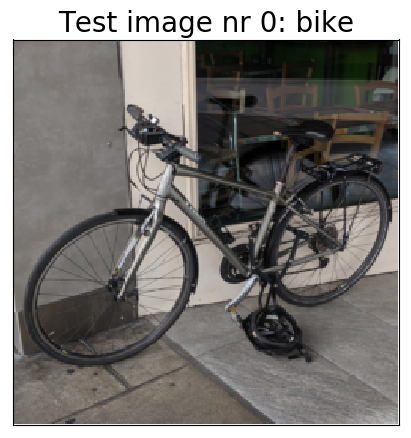

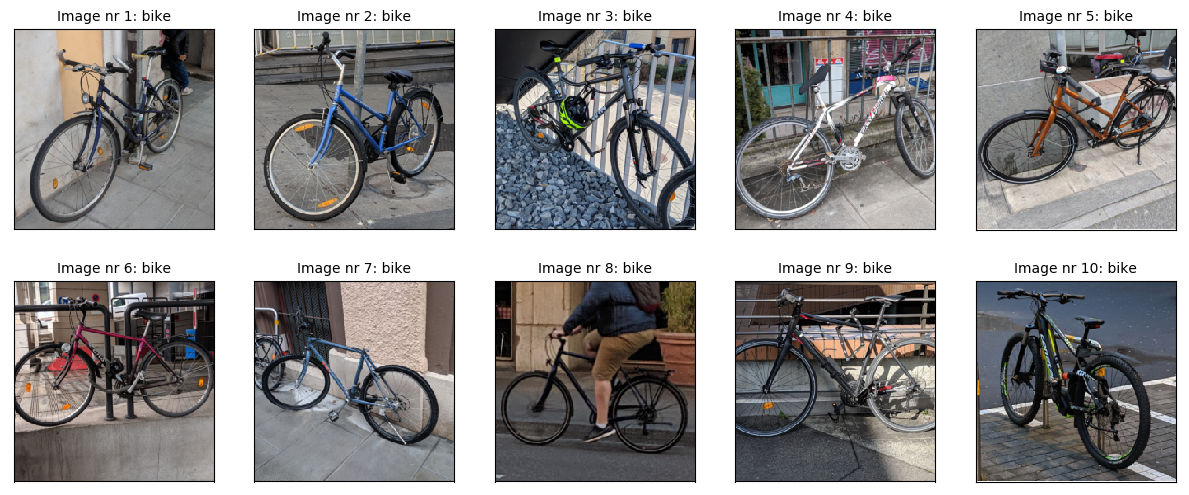

In [28]:
# plot example
img_nr = 0 # choose a number from 0 to 49

# plot example image from test data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), facecolor="white")
ax.imshow(raw_img_batch_te[img_nr])
ax.set_title(f"Test image nr {img_nr}: {y_te[img_nr]}", fontsize=20)
ax.set_xticks([])
ax.set_yticks([])
plt.show();

# plot 10 nearest neigbours selected with knn form train data
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(15,6), facecolor="white")
for i, ax in enumerate(axs.flat):
    tr_idx = img_nr_in_train_data_closes_to_target[img_nr,i]
    # ...
    ax.imshow(raw_img_batch_tr[tr_idx])
    ax.set_title(f"Image nr {i+1}: {y_tr[tr_idx]}", fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show();